In [8]:
from IPython.display import display
import IPython
import pandas as pd
from pandas import Series
import numpy as np
from random import randrange

from matplotlib import pyplot
import matplotlib.pyplot as plt
# from statsmodels.tsa.seasonal import seasonal_decompose

# np.float_ = np.float64
# from prophet import Prophet

import math
from typing import Any, List, Dict, AnyStr, Optional
from pathlib import Path
from glob import glob

from utils.dataset import MarketData
from utils.windowgenerator import WindowGenerator, compile_and_fit
import tensorflow as tf

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

### Loading Dataset

In [9]:
cot_df, auction_df, eua_df, ta_df, fundamentals_df = MarketData.latest(Path('data'))
cot_df = cot_df.set_index('Date').resample('W', origin='end').mean().reset_index()
auction_df = auction_df.set_index('Date').resample('D').mean()


### Merging Dataset

In [10]:
merged_df = pd.merge_asof(auction_df, cot_df, on='Date', direction='backward')
merged_df.ffill(inplace=True)
merged_df.bfill(inplace=True)

merged_df.loc[:, 'Pct_Change_Auc_Price'] = merged_df['Auc Price'].pct_change() * 100
merged_df = merged_df.dropna(subset=['Pct_Change_Auc_Price'])

### Train & Test Data

In [11]:
FEATURES = ['Auc Price', 'Cover Ratio', 'Auction Spot Diff', 'Median Spot Diff', 'Premium/discount-settle',
             'net_speculators', 'spec_long_%', 'spec_short_%', 'Long/Short']

train_df = merged_df[merged_df['Date'] <
                     "2022-06-01"].copy().set_index('Date')[FEATURES]
val_df = merged_df[(merged_df['Date'].dt.year == 2022) & (
    merged_df['Date'].dt.month >= 6)].copy().set_index('Date')[FEATURES]
test_df = merged_df[merged_df['Date'].dt.year == 2023].copy().set_index('Date')[FEATURES]

#### Dataset Normalization

In [12]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

num_features = train_df.shape[1]

In [13]:
train_df.head()

,Auc Price,Cover Ratio,Auction Spot Diff,Median Spot Diff,Premium/discount-settle,net_speculators,spec_long_%,spec_short_%,Long/Short
Date,,,,,,,,,
2018-06-05,-0.966950,0.479070,-0.048835,-0.129219,0.45274,0.186574,-0.892359,-1.517772,4.722487
2018-06-06,-0.997623,0.526993,-0.252857,-0.133603,0.45274,0.186574,-0.892359,-1.517772,4.722487
2018-06-07,-0.976860,0.542967,0.818257,-0.124834,0.45274,0.186574,-0.892359,-1.517772,4.722487
2018-06-08,-0.993848,-0.335628,-0.150846,-0.127026,0.45274,0.186574,-0.892359,-1.517772,4.722487
2018-06-09,-0.993848,-0.335628,-0.150846,-0.127026,0.45274,0.186574,-0.892359,-1.517772,4.722487


Total window size: 21
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14 15 16 17 18 19 20]
Label column name(s): None

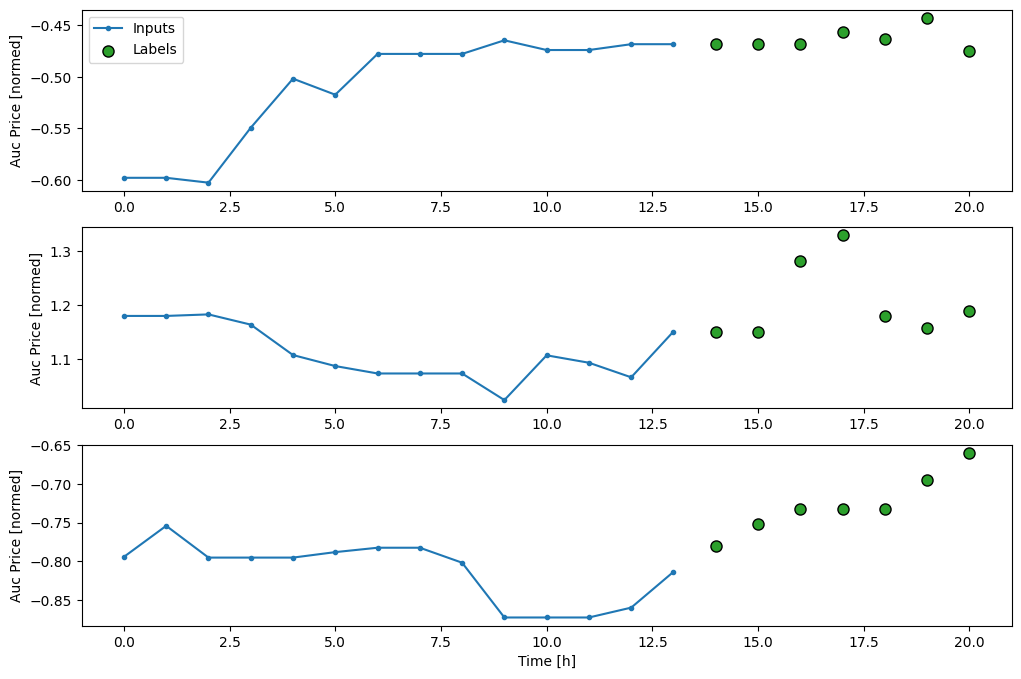

In [15]:
OUT_STEPS = 7

multi_window = WindowGenerator(input_width=14,
                               train_df=train_df, val_df=val_df, test_df=test_df,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

## Modeling

### MultiStep Last Baseline

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 0.9869 - mean_absolute_error: 0.4619


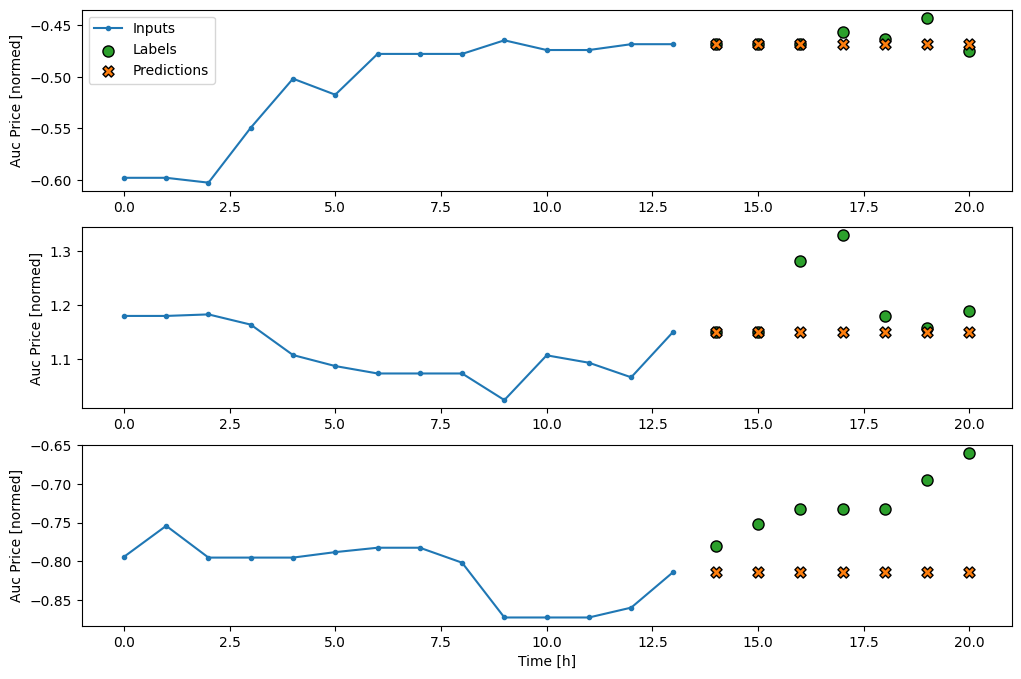

In [19]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val, return_dict=True)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(last_baseline)

### Multi Linear Model

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 0.8173 - mean_absolute_error: 0.5627
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - loss: 0.8526 - mean_absolute_error: 0.6136


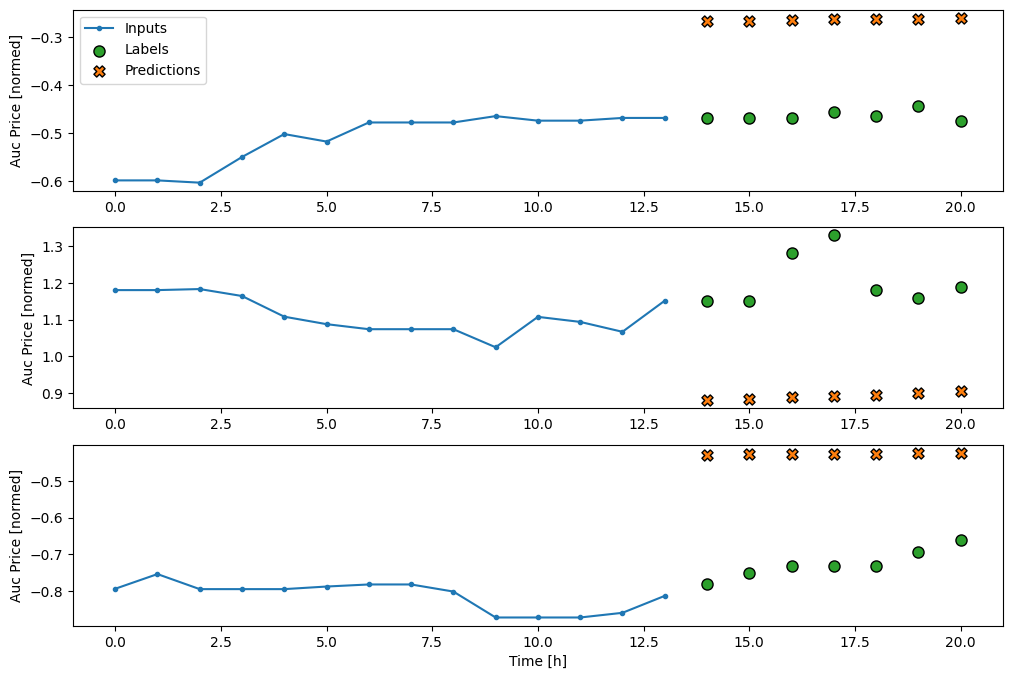

In [21]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=1, return_dict=True)
multi_window.plot(multi_linear_model)

### Dense Model

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 0.7051 - mean_absolute_error: 0.4764


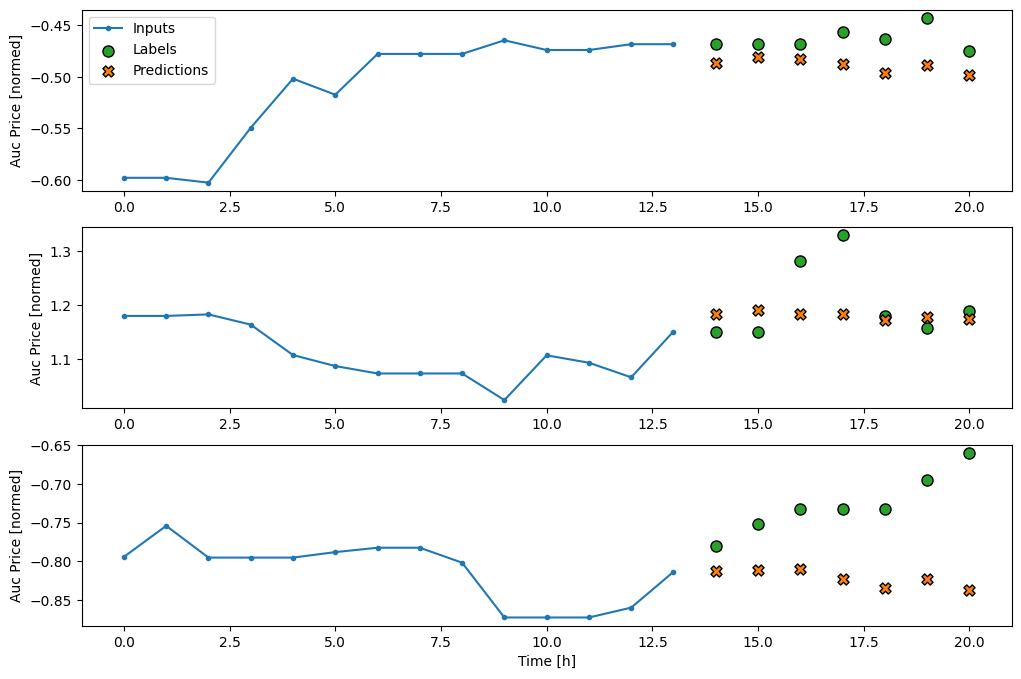

In [22]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_dense_model)

### Conv Model

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 0.7457 - mean_absolute_error: 0.5441


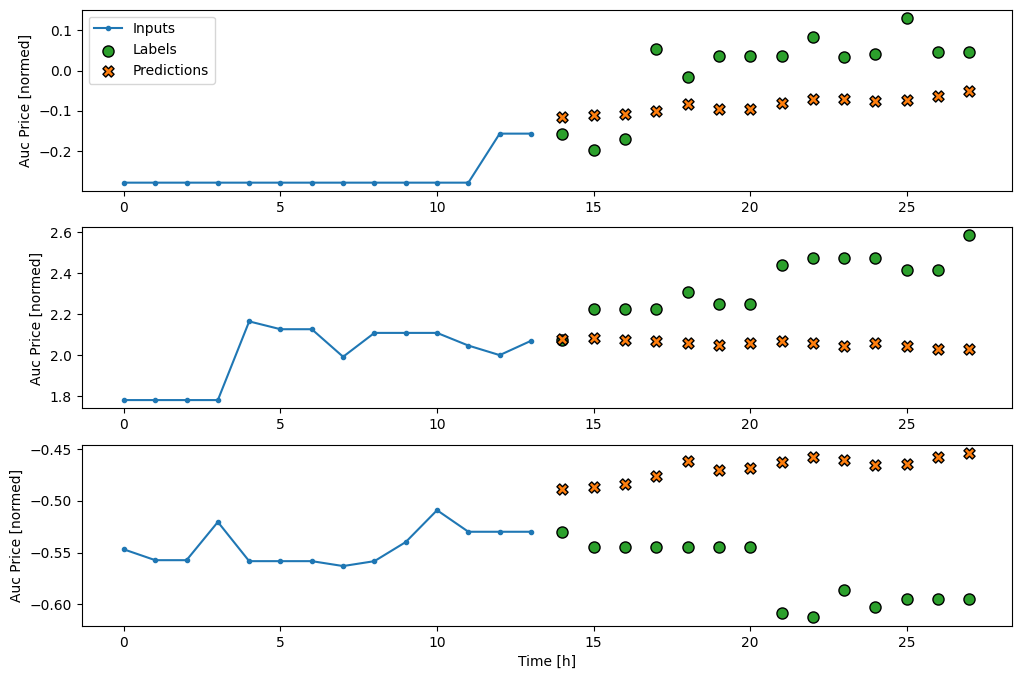

In [24]:
OUT_STEPS = 14
multi_window = WindowGenerator(input_width=14,
                               train_df=train_df, val_df=val_df, test_df=test_df,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

MAX_EPOCHS = 10
history = compile_and_fit(multi_conv_model, multi_window, MAX_EPOCHS=MAX_EPOCHS)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_conv_model)

### Multi-step LSTM Model

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 0.7924 - mean_absolute_error: 0.5720


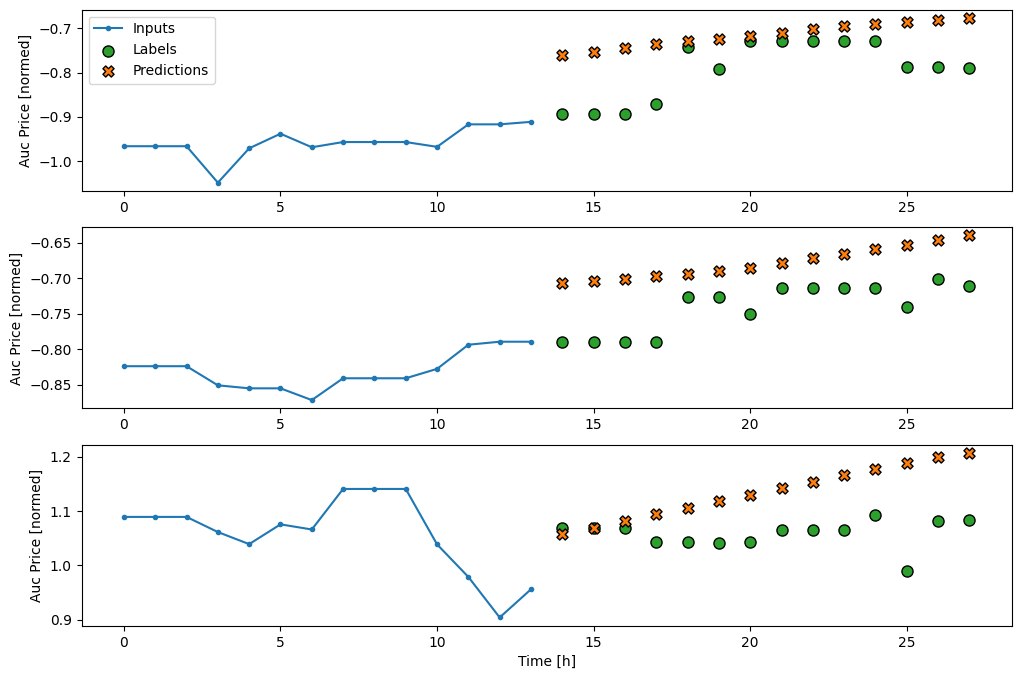

In [25]:
OUT_STEPS = 14
multi_window = WindowGenerator(input_width=14,
                               train_df=train_df, val_df=val_df, test_df=test_df,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val, return_dict=True)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_lstm_model)

### Feedback Model

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8406 - mean_absolute_error: 0.5912 


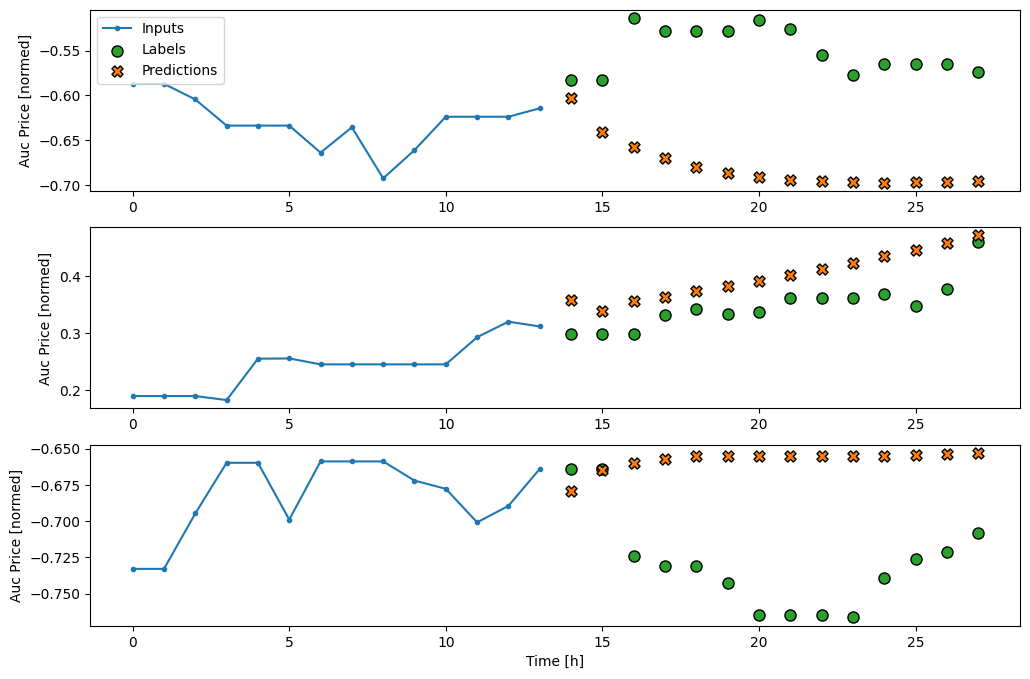

In [27]:
OUT_STEPS = 14
multi_window = WindowGenerator(input_width=14,
                               train_df=train_df, val_df=val_df, test_df=test_df,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)


class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)
    
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state


def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
FeedBack.call = call
FeedBack.warmup = warmup

prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)


history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, return_dict=True)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(feedback_model)

### Advanced AR LSTM

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8459 - mean_absolute_error: 0.6018 


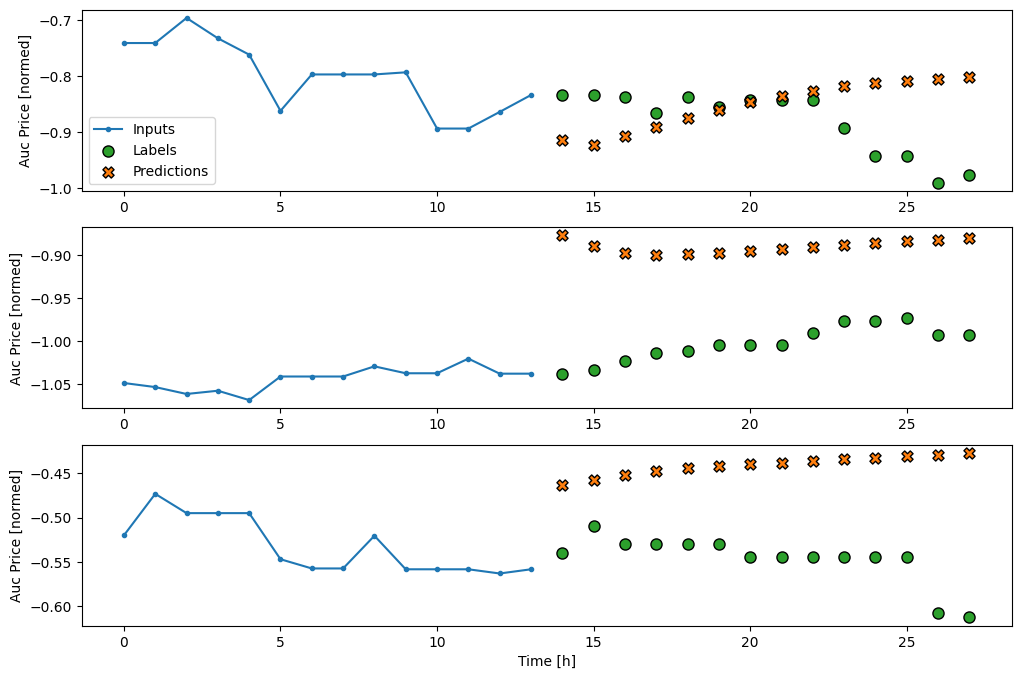

In [28]:
OUT_STEPS = 14
multi_window = WindowGenerator(input_width=14,
                               train_df=train_df, val_df=val_df, test_df=test_df,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

class AdvancedFeedBack(tf.keras.Model):
    def __init__(self, units, out_steps, num_features):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        
        # Bidirectional LSTM layer
        self.bidirectional_lstm = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(units, return_sequences=True))
        
        # Attention mechanism
        self.attention = tf.keras.layers.Attention()
        
        # Dense layers with dropout and residual connections
        self.dense1 = tf.keras.layers.Dense(units, activation='relu')
        self.dropout = tf.keras.layers.Dropout(0.3)
        self.dense = tf.keras.layers.Dense(num_features)
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        predictions.append(prediction)

        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            x = self.bidirectional_lstm(x)
            
            # Attention mechanism
            context_vector, attention_weights = self.attention([x, x], return_attention_scores=True)
            x = context_vector
            
            # Dense layers with residual connection
            x = self.dense1(x)
            x = self.dropout(x, training=training)
            prediction = self.dense(x)
            predictions.append(prediction)

        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

advanced_feedback_model = AdvancedFeedBack(units=64, out_steps=OUT_STEPS, num_features=num_features)
AdvancedFeedBack.call = call
AdvancedFeedBack.warmup = warmup

prediction, state = advanced_feedback_model.warmup(multi_window.example[0])
print('Output shape (batch, time, features): ', advanced_feedback_model(multi_window.example[0]).shape)

history = compile_and_fit(advanced_feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Advanced AR LSTM'] = advanced_feedback_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Advanced AR LSTM'] = advanced_feedback_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(advanced_feedback_model)

### Advanced AR LSTM with Multi-Head Attention

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7792 - mean_absolute_error: 0.5773 


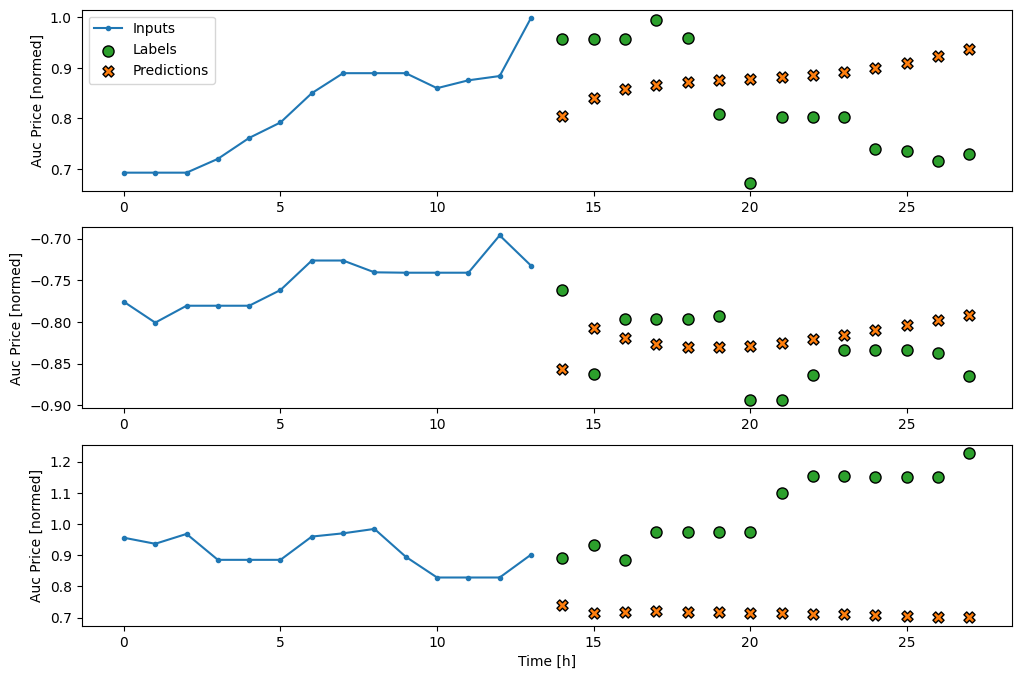

In [29]:
OUT_STEPS = 14
multi_window = WindowGenerator(input_width=14,
                               train_df=train_df, val_df=val_df, test_df=test_df,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

class AdvancedFeedBack(tf.keras.Model):
    def __init__(self, units, out_steps, num_features, num_heads=4):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        
        # Bidirectional LSTM layer
        self.bidirectional_lstm = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(units, return_sequences=True))
        
        # Multi-head attention mechanism
        # self.multi_head_attention = tf.keras.layers.MultiHeadAttention(
        #     num_heads=num_heads, key_dim=units)
        
        # Dense layers with dropout and residual connections
        self.dense1 = tf.keras.layers.Dense(units, activation='relu')
        self.dropout = tf.keras.layers.Dropout(0.3)
        self.dense = tf.keras.layers.Dense(num_features)
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        predictions.append(prediction)

        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            x = self.bidirectional_lstm(x)
            
            # Multi-head attention mechanism
            x = self.multi_head_attention(query=x, value=x)
            
            # Dense layers with residual connection
            x = self.dense1(x)
            x = self.dropout(x, training=training)
            prediction = self.dense(x)
            predictions.append(prediction)

        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

advanced_feedback_model = AdvancedFeedBack(units=64, out_steps=OUT_STEPS, num_features=num_features, num_heads=4)
AdvancedFeedBack.call = call
AdvancedFeedBack.warmup = warmup

prediction, state = advanced_feedback_model.warmup(multi_window.example[0])
print('Output shape (batch, time, features): ', advanced_feedback_model(multi_window.example[0]).shape)

history = compile_and_fit(advanced_feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Advanced AR LSTM with Multi-Head Attention'] = advanced_feedback_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Advanced AR LSTM with Multi-Head Attention'] = advanced_feedback_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(advanced_feedback_model)

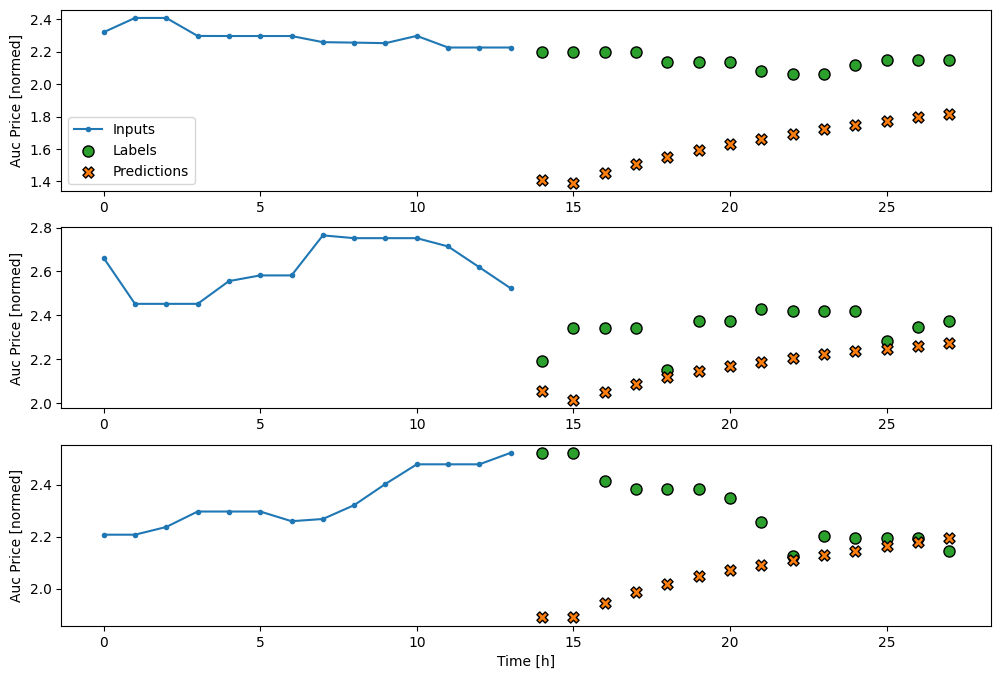

In [30]:
multi_window.plot_test(advanced_feedback_model)